In [1]:
# notebook with functions for analyzing the ignition delay results

In [50]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

import os


import cantera as ct
import cantera.ck2cti
import rmgpy.chemkin
%matplotlib inline

In [3]:
# load the base model so we know which reactions are which
basedir = '/work/westgroup/harris.se/autoscience/autoscience/butane'
base_chemkin = os.path.join(basedir, 'chem_annotated.inp')
dictionary = os.path.join(basedir, 'species_dictionary.txt')
transport = os.path.join(basedir, 'tran.dat')
species_list, reaction_list = rmgpy.chemkin.load_chemkin_file(base_chemkin, dictionary_path=dictionary, transport_path=transport)


In [51]:
covariance_file = '/work/westgroup/harris.se/autoscience/autoscience/uncertainty/butane_covariance.pickle'
with open(covariance_file, 'rb') as handle:
    Sigma_k = pickle.load(handle)

In [4]:
# recreate the orders of reactions
n_ign_delays = 5000
np.random.seed(400)
n_to_perturb = 30

orders = np.zeros((n_ign_delays, len(reaction_list)))
for i in range(0, n_ign_delays):
    orders[i, :] = np.random.permutation(len(reaction_list))
orders = orders.astype(int)

In [5]:
# Pick out the runs with the largest deviations from the base run

In [6]:
logfile = '/scratch/harris.se/autoscience/not_correlated/ignition_delays/ignition_delays_007.csv'

df = pd.read_csv(logfile, skiprows=1, names=['model', 'delay'])
# df = pd.read_csv(logfile, header=None, names=['model', 'conditions', 'delay'])

In [7]:
np.min(df['delay'].values[0:1000])

0.1103356599273211

In [8]:
np.max(df['delay'].values[0:1000])

0.1872484657234126

In [9]:
np.mean(df['delay'].values[0:1000])

0.14864684750139726

In [10]:
base_delay = 0.14857534592261107

In [11]:
# get the top 50 runs
delta = np.abs(df['delay'].values[0:1000] - base_delay)



In [12]:
best_runs = [x for _, x in sorted(zip(delta, np.arange(0, 1000)))][::-1]

In [13]:
best_runs[0]

994

In [14]:
for i in range(0, 10):
    print(df['delay'].values[0:1000][best_runs[i]])

0.1872484657234126
0.1103356599273211
0.1853060299279509
0.1120423188982754
0.1127217201526698
0.1134507960358912
0.113519343177388
0.1138817268835155
0.1144655439986231
0.1821034907086406


In [23]:
best_runs[0]

994

In [27]:
color_matrix = np.zeros((50, len(reaction_list)))

In [29]:
# mark the reactions that changed
for k, run_index in enumerate(best_runs[:50]):

    perturbed_reactions = 0
    i = 0
    while perturbed_reactions < 50:
        reaction_index = orders[run_index, i]
        i += 1
        if type(reaction_list[reaction_index].kinetics) == rmgpy.kinetics.arrhenius.MultiArrhenius:
            continue
        if type(reaction_list[reaction_index].kinetics) == rmgpy.kinetics.falloff.ThirdBody:
            continue
        if type(reaction_list[reaction_index].kinetics) == rmgpy.kinetics.falloff.Troe:
            continue
        if type(reaction_list[reaction_index].kinetics) == rmgpy.kinetics.arrhenius.PDepArrhenius:
            continue
        if type(reaction_list[reaction_index].kinetics) == rmgpy.kinetics.arrhenius.MultiPDepArrhenius:
            continue
        if type(reaction_list[reaction_index].kinetics) == rmgpy.kinetics.falloff.Lindemann:
            continue
        if type(reaction_list[reaction_index].kinetics) == rmgpy.kinetics.chebyshev.Chebyshev:
            continue

        color_matrix[k, reaction_index] = 1.0
        perturbed_reactions += 1

            


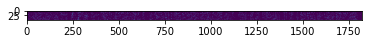

In [30]:
plt.imshow(color_matrix)

In [31]:
sums =np.sum(color_matrix, 0)

In [32]:
top_rxns = [x for _, x in sorted(zip(sums, np.arange(0, len(reaction_list))))][::-1]

In [33]:
top_rxns[0]

288

In [53]:
reaction_index = 1688
print('Reactants:')
for reactant in reaction_list[reaction_index].reactants:
    print('\t', reactant.smiles)

print('Products:')
for product in reaction_list[reaction_index].products:
    print('\t', product.smiles)

print(Sigma_k[reaction_index][reaction_index])

Reactants:
	 CCO[O]
	 C[CH]CC
Products:
	 CCOO
	 CC=CC
4.24952568387371


In [58]:
print('idx', '\t', 'delta', '\t', 'sum', '\t', 'family', '\t', 'reaction')
for i in range(0, 50):
#     print(sums[top_rxns[i]])
    delta = np.round(Sigma_k[top_rxns[i]][top_rxns[i]],1)
    print(top_rxns[i], '\t', delta, '\t', sums[top_rxns[i]], '\t', reaction_list[top_rxns[i]].family, '\t', reaction_list[top_rxns[i]])

idx 	 delta 	 sum 	 family 	 reaction
288 	 0.5 	 20.0 	 CurranPentane 	 OH(15) + butane(1) <=> H2O(8) + PC4H9(182)
247 	 0.5 	 13.0 	 CurranPentane 	 OH(15) + butane(1) <=> H2O(8) + SC4H9(183)
279 	 0.5 	 11.0 	 CurranPentane 	 SC4H9O2(186) <=> HO2(16) + C4H8-2(189)
281 	 0.5 	 8.0 	 CurranPentane 	 O2(2) + C4H8OOH2-4(223) <=> C4H8OOH2-4O2(229)
1702 	 0.5 	 6.0 	 CurranPentane 	 C4H8-1(188) + SC4H9O2(186) <=> C4H71-3(190) + SC4H9O2H(187)
1688 	 4.2 	 6.0 	 Disproportionation 	 C2H5O2(47) + SC4H9(183) <=> C2H5O2H(48) + C4H8-2(189)
1663 	 1.8 	 6.0 	 H_Abstraction 	 C2H5O2H(48) + C4H71-1,3OOH(238) <=> C2H5O2(47) + CC(CCOO)OO(787)
1592 	 1.8 	 6.0 	 Disproportionation 	 OCHO(38) + SC4H9(183) <=> HOCHO(40) + C4H8-1(188)
1529 	 10.7 	 6.0 	 Disproportionation 	 CH3O(31) + C2H5O(49) <=> CH3OH(30) + CH3CHO(35)
1398 	 1.8 	 6.0 	 Disproportionation 	 [CH2]C=C[CH2](2534) + C4H71-3(190) <=> C4H6(194) + C4H71-3(190)
877 	 3.2 	 6.0 	 Disproportionation 	 C2H5(33) + C4H8OOH1-3O2(225) <=> C2H4(11)

In [36]:
sums[288]

20.0